# L0 Regularized Dataset Optimization

This notebook demonstrates how to optimize L0 regularization parameters to produce sparse datasets that minimize both calibration loss and dataset size. We'll test various parameter combinations and compare their performance across multiple metrics.

## Setup and Imports

In [1]:
# Must run uv pip install microcalibrate

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import warnings
import logging
from pathlib import Path
import h5py

# Import Hugging Face Hub for dataset download
from huggingface_hub import hf_hub_download

# Configure logging to reduce noise during optimization
logging.getLogger('microcalibrate').setLevel(logging.WARNING)
warnings.filterwarnings('ignore')

# Import microcalibrate modules
import sys
sys.path.append('../src')
from microcalibrate.calibration import Calibration
from microcalibrate.utils.l0 import evaluate_sparse_weights
from microcalibrate.evaluation import evaluate_estimate_distance_to_targets

# Import PolicyEngine US data modules
sys.path.append('../../policyengine-us-data')
sys.path.append('../../policyengine-us')

from policyengine_us_data.datasets import EnhancedCPS_2024
from policyengine_us_data.utils import build_loss_matrix
from policyengine_us_data.datasets.cps.extended_cps import ExtendedCPS_2024
from policyengine_us import Microsimulation
from policyengine_core.data import Dataset

print("✓ All modules imported successfully")

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

/Users/elenacura/Desktop/PolicyEngine/policyengine-us-data/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ All modules imported successfully


## Load Enhanced CPS Dataset

We'll load the real Enhanced Current Population Survey (ECPS) dataset from PolicyEngine US data, which includes both the survey microdata and calibration targets derived from administrative sources (IRS, Census, BLS, etc.).

In [2]:
def get_data_directory() -> Path:
    """
    Get the data directory for storing downloaded datasets.
    """
    # Create a data directory in the current notebook directory
    data_dir = Path("../data/input/enhanced_cps")
    data_dir.mkdir(parents=True, exist_ok=True)
    return data_dir

def get_enhanced_cps_dataset(time_period=2024) -> Dataset:
    """
    Download and load Enhanced CPS dataset from Hugging Face Hub.
    """
    print("Downloading Enhanced CPS dataset from Hugging Face...")
    
    # Download the dataset file from Hugging Face Hub
    dataset_path = hf_hub_download(
        repo_id="policyengine/policyengine-us-data",
        filename="enhanced_cps_2024.h5",
        local_dir=get_data_directory(),
    )
    
    print(f"✅ Dataset downloaded to: {dataset_path}")
    
    # Load the dataset using PolicyEngine's Dataset class
    dataset = Dataset.from_file(dataset_path, time_period=time_period)
    
    return dataset

def retrieve_calibration_inputs(year=2024):
    """
    Load Enhanced CPS dataset using proper Hugging Face Hub download.
    
    Args:
        year: Year of data to load
        subsample_size: Number of households to sample for computational efficiency
    
    Returns:
        weights, estimate_matrix, targets, target_names
    """
    print(f"Loading Enhanced CPS {year} dataset...")
    
    # Get the Enhanced CPS dataset from Hugging Face
    ecps_dataset = get_enhanced_cps_dataset(time_period=year)
    
    # Create simulation using the loaded dataset
    sim = Microsimulation(dataset=ecps_dataset)
    
    # Get original household weights
    original_weights = sim.calculate("household_weight", year).values
    print(f"Original weights - mean: {original_weights.mean():.2f}, std: {original_weights.std():.2f}")
    
    # Build loss matrix and targets from administrative sources
    print("Building calibration targets from administrative data...")
    loss_matrix, targets_array = build_loss_matrix(EnhancedCPS_2024, year)
    
    # Clean targets - remove problematic ones identified in production
    problematic_targets = [
        "nation/irs/adjusted gross income/total/AGI in 10k-15k/taxable/Head of Household",
        "nation/irs/adjusted gross income/total/AGI in 15k-20k/taxable/Head of Household", 
        "nation/irs/adjusted gross income/total/AGI in 10k-15k/taxable/Married Filing Jointly/Surviving Spouse",
        "nation/irs/adjusted gross income/total/AGI in 15k-20k/taxable/Married Filing Jointly/Surviving Spouse",
        "nation/irs/count/count/AGI in 10k-15k/taxable/Head of Household",
        "nation/irs/count/count/AGI in 15k-20k/taxable/Head of Household",
        "nation/irs/count/count/AGI in 10k-15k/taxable/Married Filing Jointly/Surviving Spouse", 
        "nation/irs/count/count/AGI in 15k-20k/taxable/Married Filing Jointly/Surviving Spouse",
        "state/RI/adjusted_gross_income/amount/-inf_1",
        "nation/irs/exempt interest/count/AGI in -inf-inf/taxable/All",
    ]
    
    # Filter out zero targets and problematic targets
    zero_mask = np.isclose(targets_array, 0.0, atol=0.1)
    problematic_mask = loss_matrix.columns.isin(problematic_targets)
    keep_mask = ~(zero_mask | problematic_mask)
    keep_indices = np.where(keep_mask)[0]
    
    # Apply filters
    loss_matrix_clean = loss_matrix.iloc[:, keep_indices]
    targets_clean = targets_array[keep_indices]
    target_names_clean = loss_matrix_clean.columns.values
    
    print(f"Filtered targets: {len(targets_array)} → {len(targets_clean)} usable targets")
    
    # Align dimensions (subsample loss matrix if needed)
    min_size = min(len(original_weights), len(loss_matrix_clean))
    if len(loss_matrix_clean) > min_size:
        loss_matrix_clean = loss_matrix_clean.iloc[:min_size]
    if len(original_weights) > min_size:
        original_weights = original_weights[:min_size]
    
    print(f"✅ Dataset loaded: {len(original_weights):,} households, {len(targets_clean)} targets")
    
    return original_weights, loss_matrix_clean, targets_clean, target_names_clean

# Load the Enhanced CPS dataset from Hugging Face
print("=" * 70)
print("LOADING ENHANCED CPS DATASET FROM HUGGING FACE")
print("=" * 70)

weights, estimate_matrix, targets, target_names = retrieve_calibration_inputs(
    year=2024,
)

# Display dataset overview
print(f"\n{'='*70}")
print("ENHANCED CPS DATASET OVERVIEW")
print("="*70)
print(f"📊 Households: {len(weights):,}")
print(f"🎯 Calibration Targets: {len(targets)}")
print(f"📈 Estimate Matrix: {estimate_matrix.shape}")

print(f"\n🏛️  Administrative Target Sources (first 10):")
for i, name in enumerate(target_names[:10]):
    source = "IRS" if "irs" in name else "Census" if "census" in name else "State" if "state" in name else "Federal"
    print(f"  {i+1:2d}. [{source:6s}] {name}")

if len(target_names) > 10:
    print(f"  ... and {len(target_names)-10} more targets from IRS, Census, and state sources")

print(f"\n💰 Target Value Statistics:")
print(f"  Minimum: ${targets.min():,.0f}")
print(f"  Median:  ${np.median(targets):,.0f}")
print(f"  Maximum: ${targets.max():,.0f}")

print(f"\n⚖️  Weight Statistics:")
print(f"  Mean: {weights.mean():.2f}")
print(f"  Std:  {weights.std():.2f}")
print(f"  Range: {weights.min():.2f} - {weights.max():.2f}")

print(f"\n✅ Ready for L0 regularization optimization!")

LOADING ENHANCED CPS DATASET FROM HUGGING FACE
Loading Enhanced CPS 2024 dataset...
✅ Dataset downloaded to: ../data/input/enhanced_cps/enhanced_cps_2024.h5
Original weights - mean: 3579.99, std: 11627.53
Building calibration targets from administrative data...


INFO:root:Targeting Medicaid enrollment for AK with target 231577k
INFO:root:Targeting Medicaid enrollment for AL with target 766009k
INFO:root:Targeting Medicaid enrollment for AR with target 733561k
INFO:root:Targeting Medicaid enrollment for AZ with target 1778734k
INFO:root:Targeting Medicaid enrollment for CA with target 12172695k
INFO:root:Targeting Medicaid enrollment for CO with target 1058326k
INFO:root:Targeting Medicaid enrollment for CT with target 904321k
INFO:root:Targeting Medicaid enrollment for DC with target 240020k
INFO:root:Targeting Medicaid enrollment for DE with target 236840k
INFO:root:Targeting Medicaid enrollment for FL with target 3568648k
INFO:root:Targeting Medicaid enrollment for GA with target 1699279k
INFO:root:Targeting Medicaid enrollment for HI with target 376318k
INFO:root:Targeting Medicaid enrollment for IA with target 586748k
INFO:root:Targeting Medicaid enrollment for ID with target 296968k
INFO:root:Targeting Medicaid enrollment for IL with targ

Filtered targets: 2813 → 2801 usable targets
✅ Dataset loaded: 41,310 households, 2801 targets

ENHANCED CPS DATASET OVERVIEW
📊 Households: 41,310
🎯 Calibration Targets: 2801
📈 Estimate Matrix: (41310, 2801)

🏛️  Administrative Target Sources (first 10):
   1. [IRS   ] nation/irs/adjusted gross income/total/AGI in -inf-inf/taxable/All
   2. [IRS   ] nation/irs/adjusted gross income/total/AGI in 10k-15k/taxable/All
   3. [IRS   ] nation/irs/adjusted gross income/total/AGI in 15k-20k/taxable/All
   4. [IRS   ] nation/irs/adjusted gross income/total/AGI in 20k-25k/taxable/All
   5. [IRS   ] nation/irs/adjusted gross income/total/AGI in 25k-30k/taxable/All
   6. [IRS   ] nation/irs/adjusted gross income/total/AGI in 30k-40k/taxable/All
   7. [IRS   ] nation/irs/adjusted gross income/total/AGI in 40k-50k/taxable/All
   8. [IRS   ] nation/irs/adjusted gross income/total/AGI in 50k-75k/taxable/All
   9. [IRS   ] nation/irs/adjusted gross income/total/AGI in 75k-100k/taxable/All
  10. [IRS   ]

## Define Optimization Framework

We'll create functions to run L0 calibration with different parameters and evaluate the results.

I use Mean Relative Absolute Error as the primary Loss value, but this still might not be the same as how loss is calculated for the full ECPS? Might be missing some state/district level normalization & inverting???

In [ ]:
def run_l0_calibration(weights, estimate_matrix, targets, target_names, 
                       l0_lambda, temperature, init_mean, epochs=1000):
    """
    Run L0 calibration with specified parameters.
    
    Returns:
        Dictionary with calibration results and metrics
    """
    try:
        calibrator = Calibration(
            weights=weights,
            targets=targets,
            target_names=target_names,
            estimate_matrix=estimate_matrix,
            regularize_with_l0=True,
            l0_lambda=l0_lambda,
            temperature=temperature,
            init_mean=init_mean,
            epochs=epochs,
            learning_rate=1e-3,
            #dropout_rate=0.05,
            noise_level=10.0
        )
        
        # Run calibration
        performance_df = calibrator.calibrate()
        
        # Extract results
        dense_weights = calibrator.weights
        sparse_weights = calibrator.sparse_weights
        
        # Calculate metrics
        results = calculate_metrics(
            weights, dense_weights, sparse_weights, 
            estimate_matrix, targets, target_names,
            l0_lambda, temperature, init_mean
        )
        
        results['performance_df'] = performance_df
        results['calibrator'] = calibrator
        results['success'] = True
        
        return results
        
    except Exception as e:
        return {
            'success': False,
            'error': str(e),
            'l0_lambda': l0_lambda,
            'temperature': temperature,
            'init_mean': init_mean
        }

def calculate_metrics(original_weights, dense_weights, sparse_weights, 
                     estimate_matrix, targets, target_names,
                     l0_lambda, temperature, init_mean):
    """
    Calculate comprehensive metrics for L0 calibration results.
    """
    # Basic parameters
    metrics = {
        'l0_lambda': l0_lambda,
        'temperature': temperature,
        'init_mean': init_mean
    }
    
    # Dataset size metrics
    original_size = len(original_weights)
    sparse_size = np.sum(sparse_weights > 0)
    sparsity_ratio = np.sum(sparse_weights == 0) / len(sparse_weights)
    size_reduction_pct = (original_size - sparse_size) / original_size * 100
    
    metrics.update({
        'original_size': original_size,
        'sparse_size': sparse_size,
        'sparsity_ratio': sparsity_ratio,
        'size_reduction_pct': size_reduction_pct
    })
    
    # Calibration accuracy metrics
    dense_estimates = dense_weights @ estimate_matrix.values
    sparse_estimates = sparse_weights @ estimate_matrix.values
    
    # Calculate errors
    dense_errors = dense_estimates - targets
    sparse_errors = sparse_estimates - targets
    dense_abs_errors = np.abs(dense_errors)
    sparse_abs_errors = np.abs(sparse_errors)
    
    # Avoid division by zero in relative absolute error calculation
    targets_safe = np.where(np.abs(targets) < 1e-6, 1e-6, targets)
    dense_rel_abs_errors = dense_abs_errors / np.abs(targets_safe)
    sparse_rel_abs_errors = sparse_abs_errors / np.abs(targets_safe)
    
    # Mean squared error (legacy)
    dense_mse = np.mean(dense_errors ** 2)
    sparse_mse = np.mean(sparse_errors ** 2)
    
    # NEW PRIMARY METRIC: Mean Relative Absolute Error
    dense_mrae = np.mean(dense_rel_abs_errors) * 100
    sparse_mrae = np.mean(sparse_rel_abs_errors) * 100
    
    # Mean absolute percentage error (legacy)
    dense_mape = np.mean(np.abs(dense_errors / targets_safe)) * 100
    sparse_mape = np.mean(np.abs(sparse_errors / targets_safe)) * 100
    
    # Percentage of targets within tolerance
    dense_within_10pct = np.mean(dense_rel_abs_errors <= 0.1) * 100
    sparse_within_10pct = np.mean(sparse_rel_abs_errors <= 0.1) * 100
    
    metrics.update({
        'dense_mse': dense_mse,
        'sparse_mse': sparse_mse,
        'dense_mrae': dense_mrae,  # NEW PRIMARY METRIC
        'sparse_mrae': sparse_mrae,  # NEW PRIMARY METRIC
        'dense_mape': dense_mape,
        'sparse_mape': sparse_mape,
        'dense_within_10pct': dense_within_10pct,
        'sparse_within_10pct': sparse_within_10pct
    })
    
    # Weight distribution metrics
    sparse_weights_nonzero = sparse_weights[sparse_weights > 0]
    
    metrics.update({
        'sparse_weight_mean': np.mean(sparse_weights_nonzero) if len(sparse_weights_nonzero) > 0 else 0,
        'sparse_weight_std': np.std(sparse_weights_nonzero) if len(sparse_weights_nonzero) > 0 else 0,
        'sparse_weight_max': np.max(sparse_weights_nonzero) if len(sparse_weights_nonzero) > 0 else 0,
        'sparse_weight_min': np.min(sparse_weights_nonzero) if len(sparse_weights_nonzero) > 0 else 0
    })
    
    # Combined objective function (minimize both loss and size)
    # Weight accuracy vs sparsity (adjust alpha to preference)
    alpha = 0.5  # Balance between accuracy and sparsity
    # Use relative absolute error instead of MSE
    normalized_loss = sparse_mrae / 100  # Normalize to 0-1 scale
    objective_score = alpha * normalized_loss + (1 - alpha) * (1 - sparsity_ratio)
    
    metrics['objective_score'] = objective_score
    
    return metrics

def export_calibration_logs(results_df, target_names, output_dir='../results'):
    """
    Export top 10 calibration results to calibration_log.csv format expected by dashboard.
    """
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True)
    
    # Get top 10 configurations
    top_10 = results_df.nsmallest(10, 'objective_score')
    
    calibration_logs = []
    
    for rank, (idx, config) in enumerate(top_10.iterrows()):
        if 'performance_df' not in config or config['performance_df'] is None:
            continue
            
        performance_df = config['performance_df']
        
        # Get final epoch data
        final_epoch = performance_df.iloc[-1] if len(performance_df) > 0 else None
        
        if final_epoch is None:
            continue
        
        # Create calibrator object to get final estimates
        try:
            # Get estimates and targets for this configuration
            calibrator = config.get('calibrator')
            if calibrator is None:
                continue
                
            sparse_weights = calibrator.sparse_weights
            estimate_matrix = calibrator.estimate_matrix
            targets = calibrator.targets
            
            # Calculate final estimates
            estimates = sparse_weights @ estimate_matrix.values
            
            # Create log entries for each target
            for i, target_name in enumerate(target_names):
                if i >= len(targets) or i >= len(estimates):
                    continue
                    
                target_val = targets[i]
                estimate_val = estimates[i]
                error = estimate_val - target_val
                abs_error = abs(error)
                rel_abs_error = abs_error / abs(target_val) if abs(target_val) > 1e-6 else 0
                
                log_entry = {
                    'rank': rank + 1,
                    'config_id': f"λ={config['l0_lambda']:.0e}_T={config['temperature']}_μ={config['init_mean']:.3f}",
                    'epoch': len(performance_df) - 1,
                    'loss': config['sparse_mrae'] / 100,  # Use MRAE as loss
                    'target_name': target_name,
                    'target': target_val,
                    'estimate': estimate_val,
                    'error': error,
                    'abs_error': abs_error,
                    'rel_abs_error': rel_abs_error,
                    'l0_lambda': config['l0_lambda'],
                    'temperature': config['temperature'],
                    'init_mean': config['init_mean'],
                    'size_reduction_pct': config['size_reduction_pct'],
                    'sparse_within_10pct': config['sparse_within_10pct'],
                    'objective_score': config['objective_score']
                }
                
                calibration_logs.append(log_entry)
                
        except Exception as e:
            print(f"Warning: Could not process configuration {rank+1}: {e}")
            continue
    
    if calibration_logs:
        # Convert to DataFrame
        log_df = pd.DataFrame(calibration_logs)
        
        # Save to CSV
        log_path = output_dir / 'calibration_log.csv'
        log_df.to_csv(log_path, index=False)
        
        print(f"📊 Calibration log exported: {log_path}")
        print(f"   • {len(log_df):,} entries across {len(top_10)} configurations")
        print(f"   • {len(target_names)} targets per configuration")
        
        return log_df
    else:
        print("❌ No calibration logs could be generated")
        return None

print("Optimization framework updated with Relative Absolute Error metric!")

Optimization framework updated with Relative Absolute Error metric!


## Parameter Grid Search

We'll test various combinations of L0 regularization parameters to find the optimal balance between calibration accuracy and dataset size reduction.

In [ ]:
# Define L0 regularization parameter grid for optimization
param_grid = {
    'l0_lambda': [5e-6, 1e-5, 2e-5],     # Sparsity strength (key parameter)
    'temperature': [0.5, 1.0, 1.5, 2.0],       # Sparsity sharpness 
} # Removed init_mean as it's not an important parameter to finetune, 0.999-1.000 are fine.

print("🔧 L0 REGULARIZATION PARAMETER GRID")
print("="*50)
for param, values in param_grid.items():
    print(f"{param:12s}: {values}")

total_combinations = np.prod([len(v) for v in param_grid.values()])
estimated_time = total_combinations * 1.5  # ~1.5 min per combination

print(f"\n📈 Optimization Scale:")
print(f"  Total combinations: {total_combinations}")
print(f"  Estimated runtime: ~{estimated_time:.0f} minutes")
print(f"  Target dataset: {len(weights):,} households → sparse subset")

🔧 L0 REGULARIZATION PARAMETER GRID
l0_lambda   : [5e-06, 1e-05, 2e-05]
temperature : [0.5, 1.0, 1.5, 2.0]

📈 Optimization Scale:
  Total combinations: 12
  Estimated runtime: ~18 minutes
  Target dataset: 41,310 households → sparse subset


### Run Grid Search

In [ ]:
def run_greedy_l0_optimization(weights, estimate_matrix, targets, target_names, max_evaluations=50):
    """
    Greedy L0 parameter optimization using coarse-to-fine search strategy.
    """
    print("🎯 GREEDY L0 PARAMETER OPTIMIZATION")
    print("="*50)
    
    best_result = None
    best_score = float('inf')
    evaluation_count = 0
    
    init_mean = 0.9999  # Fixed initial mean for all Phase 1 calibrations
    
    # Phase 1: Complete grid search with fixed init_mean
    print("\n📡 Phase 1: Complete Grid Search (Fixed init_mean)")
    print(f"    Using fixed init_mean = {init_mean}")
    
    phase1_results = []
    
    # Run through ALL combinations of l0_lambda and temperature
    for l0_lambda in param_grid['l0_lambda']:
        for temperature in param_grid['temperature']:
            evaluation_count += 1
            print(f"  [{evaluation_count:2d}] Testing λ={l0_lambda:.0e}, T={temperature}, μ={init_mean}")
            
            result = run_l0_calibration(
                weights, estimate_matrix, targets, target_names,
                l0_lambda, temperature, init_mean, epochs=800
            )
            
            if result['success']:
                phase1_results.append(result)
                if result['objective_score'] < best_score:
                    best_score = result['objective_score']
                    best_result = result
                    print(f"       ✓ New best: Score={best_score:.4f}, Size↓={result['size_reduction_pct']:.1f}%")
            else:
                print(f"       ✗ Failed: {result.get('error', 'Unknown error')}")
    
    if not best_result:
        print("❌ Phase 1 failed - no successful calibrations")
        return phase1_results  # Return empty or failed results
    
    print(f"\n📊 Phase 1 Complete: {len(phase1_results)} successful runs out of {len(param_grid['l0_lambda']) * len(param_grid['temperature'])}")
    
    # Phase 2: Fine-tuned search around best region (limited by max_evaluations)
    print(f"\n🔍 Phase 2: Fine-tuned Search Around Best Parameters")
    print(f"    Best from Phase 1: λ={best_result['l0_lambda']:.0e}, T={best_result['temperature']}, μ={best_result['init_mean']}")
    print(f"    Phase 2 limited to {max_evaluations - evaluation_count} additional evaluations")
    
    # Create refined grid around best parameters
    best_lambda = best_result['l0_lambda']
    best_temp = best_result['temperature']
    best_init = best_result['init_mean']
    
    # Generate refined ranges (±50% around best values)
    refined_grid = {
        'l0_lambda': [
            best_lambda * 0.5,
            best_lambda * 0.75, 
            best_lambda,
            best_lambda * 1.5,
            best_lambda * 2.0
        ],
        'temperature': [
            max(0.1, best_temp * 0.7),
            best_temp * 0.85,
            best_temp,
            best_temp * 1.15,
            min(3.0, best_temp * 1.3)
        ],
        'init_mean': [
            max(0.9, best_init - 0.01),
            max(0.9, best_init - 0.005),
            best_init,
            min(0.9999, best_init + 0.005),
            min(0.9999, best_init + 0.01)
        ]
    }
    
    phase2_results = []
    phase2_evaluations = 0
    
    for l0_lambda in refined_grid['l0_lambda']:
        for temperature in refined_grid['temperature']:
            for init_mean_refined in refined_grid['init_mean']:
                # Only apply evaluation limit to Phase 2
                if evaluation_count >= max_evaluations:
                    print(f"    ⏹️  Stopping Phase 2: reached max_evaluations ({max_evaluations})")
                    break
                    
                # Skip if we already tested this exact combination in Phase 1
                if (abs(l0_lambda - best_result['l0_lambda']) < 1e-7 and
                    abs(temperature - best_result['temperature']) < 0.01 and
                    abs(init_mean_refined - best_result['init_mean']) < 0.001):
                    continue
                
                evaluation_count += 1
                phase2_evaluations += 1
                print(f"  [{evaluation_count:2d}] Refining λ={l0_lambda:.0e}, T={temperature:.2f}, μ={init_mean_refined:.3f}")
                
                result = run_l0_calibration(
                    weights, estimate_matrix, targets, target_names,
                    l0_lambda, temperature, init_mean_refined, epochs=1000
                )
                
                if result['success']:
                    phase2_results.append(result)
                    if result['objective_score'] < best_score:
                        improvement = (best_score - result['objective_score']) / best_score * 100
                        best_score = result['objective_score']
                        best_result = result
                        print(f"       ✓ New best: Score={best_score:.4f} ({improvement:.1f}% improvement)")
                else:
                    print(f"       ✗ Failed: {result.get('error', 'Unknown error')}")
                    
            if evaluation_count >= max_evaluations:
                break
        if evaluation_count >= max_evaluations:
            break
    
    # Combine all results
    all_results = phase1_results + phase2_results
    
    print(f"\n🏆 GREEDY OPTIMIZATION COMPLETE")
    print(f"    Phase 1 evaluations: {len(param_grid['l0_lambda']) * len(param_grid['temperature'])}")
    print(f"    Phase 2 evaluations: {phase2_evaluations}")
    print(f"    Total evaluations: {evaluation_count}")
    print(f"    Successful runs: {len(all_results)}")
    if best_result:
        print(f"    Best score: {best_score:.4f}")
        print(f"    Optimal parameters: λ={best_result['l0_lambda']:.0e}, T={best_result['temperature']:.2f}, μ={best_result['init_mean']:.3f}")
    
    return all_results

# Run the greedy optimization
print("⏱️  Starting greedy L0 parameter optimization...")
print("   Phase 1: Complete grid search with fixed init_mean")
print("   Phase 2: Greedy refinement around best parameters")

optimization_results = run_greedy_l0_optimization(
    weights, estimate_matrix, targets, target_names, 
    max_evaluations=6  # Only limits Phase 2 refinement
)

## Results Analysis

Let's analyze the results and identify the best parameter combinations.

In [6]:
# Filter successful results and create DataFrame
successful_results = [r for r in optimization_results if r['success']]
print(f"Successful runs: {len(successful_results)} out of {len(optimization_results)}")

if len(successful_results) == 0:
    print("No successful calibrations. Try adjusting parameters or increasing epochs.")
else:
    # Create results DataFrame
    results_df = pd.DataFrame(successful_results)
    
    # Remove non-numeric columns for analysis
    numeric_cols = results_df.select_dtypes(include=[np.number]).columns
    results_df_numeric = results_df[numeric_cols]
    
    print(f"\nResults DataFrame shape: {results_df.shape}")
    print(f"Columns: {list(results_df.columns)}")

Successful runs: 12 out of 12

Results DataFrame shape: (12, 23)
Columns: ['l0_lambda', 'temperature', 'init_mean', 'original_size', 'sparse_size', 'sparsity_ratio', 'size_reduction_pct', 'dense_mse', 'sparse_mse', 'dense_mrae', 'sparse_mrae', 'dense_mape', 'sparse_mape', 'dense_within_10pct', 'sparse_within_10pct', 'sparse_weight_mean', 'sparse_weight_std', 'sparse_weight_max', 'sparse_weight_min', 'objective_score', 'performance_df', 'calibrator', 'success']


### Top Performing Configurations

In [7]:
if len(successful_results) > 0:
    # Sort by objective score (lower is better)
    top_results = results_df.nsmallest(10, 'objective_score')
    
    print("🏆 TOP 10 L0 REGULARIZATION CONFIGURATIONS")
    print("="*90)
    print(f"{'Rank':<4} {'λ (L0)':<8} {'Temp':<6} {'μ (Init)':<8} {'Size ↓':<8} {'Loss (MRAE)':<12} {'Acc %':<6} {'Score':<8}")
    print("-"*90)
    
    for i, (idx, row) in enumerate(top_results.iterrows()):
        print(f"{i+1:<4} {row['l0_lambda']:<8.0e} {row['temperature']:<6.1f} {row['init_mean']:<8.3f} "
              f"{row['size_reduction_pct']:<8.2f} {row['sparse_mrae']:<12.2f} {row['sparse_within_10pct']:<6.2f} {row['objective_score']:<8.4f}")
    
    print(f"\n📊 OPTIMIZATION SUMMARY")
    print("="*50)
    print(f"Successful configurations: {len(successful_results)}/{len(optimization_results)}")
    print(f"Size reduction range: {results_df['size_reduction_pct'].min():.1f}% - {results_df['size_reduction_pct'].max():.1f}%")
    print(f"Accuracy range: {results_df['sparse_within_10pct'].min():.3f}% - {results_df['sparse_within_10pct'].max():.3f}% targets within 10%")
    print(f"MRAE loss range: {results_df['sparse_mrae'].min():.2f}% - {results_df['sparse_mrae'].max():.2f}%")
    print(f"Best objective score: {results_df['objective_score'].min():.4f}")
    
    # Identify best configuration for each metric
    best_sparsity = results_df.loc[results_df['size_reduction_pct'].idxmax()]
    best_accuracy = results_df.loc[results_df['sparse_within_10pct'].idxmax()]
    best_loss = results_df.loc[results_df['sparse_mrae'].idxmin()]
    best_overall = results_df.loc[results_df['objective_score'].idxmin()]
    
    print(f"\n🎯 SPECIALIZED RECOMMENDATIONS:")
    print(f"Most Sparse:    λ={best_sparsity['l0_lambda']:.0e}, T={best_sparsity['temperature']}, μ={best_sparsity['init_mean']:.3f} → {best_sparsity['size_reduction_pct']:.1f}% reduction")
    print(f"Most Accurate:  λ={best_accuracy['l0_lambda']:.0e}, T={best_accuracy['temperature']}, μ={best_accuracy['init_mean']:.3f} → {best_accuracy['sparse_within_10pct']:.0f}% accuracy")
    print(f"Lowest Loss:    λ={best_loss['l0_lambda']:.0e}, T={best_loss['temperature']}, μ={best_loss['init_mean']:.3f} → {best_loss['sparse_mrae']:.2f}% MRAE")
    print(f"Best Balance:   λ={best_overall['l0_lambda']:.0e}, T={best_overall['temperature']}, μ={best_overall['init_mean']:.3f} → Score {best_overall['objective_score']:.4f}")
else:
    print("❌ No successful calibrations found.")
    print("\n🔧 Troubleshooting suggestions:")
    print("  • Increase epochs to 2000-5000 for better convergence")
    print("  • Try smaller l0_lambda values (1e-7 to 1e-6)")
    print("  • Check target values are reasonable and achievable")
    print("  • Verify dataset quality and preprocessing")

🏆 TOP 10 L0 REGULARIZATION CONFIGURATIONS
Rank λ (L0)   Temp   μ (Init) Size ↓   Loss (MRAE)  Acc %  Score   
------------------------------------------------------------------------------------------
1    2e-05    0.5    1.000    94.82    3.36         94.86  0.0427  
2    1e-05    0.5    1.000    93.08    2.77         95.79  0.0484  
3    2e-05    1.0    1.000    90.68    2.51         95.86  0.0591  
4    5e-06    0.5    1.000    90.66    2.58         95.86  0.0596  
5    1e-05    1.0    1.000    87.85    2.46         96.07  0.0731  
6    5e-06    1.0    1.000    83.13    2.35         96.00  0.0961  
7    2e-05    1.5    1.000    83.12    2.43         96.00  0.0966  
8    1e-05    1.5    1.000    4.09     2.77         95.89  0.4934  
9    2e-05    2.0    1.000    1.30     2.46         96.07  0.5058  
10   1e-05    2.0    1.000    0.59     2.46         95.97  0.5094  

📊 OPTIMIZATION SUMMARY
Successful configurations: 12/12
Size reduction range: 0.4% - 94.8%
Accuracy range: 94.859% - 9

### Detailed Analysis of Best Configuration

In [8]:
if len(successful_results) > 0:
    # Get best configuration
    best_idx = results_df['objective_score'].idxmin()
    best_config = results_df.loc[best_idx]
    
    print("🎯 BEST CONFIGURATION DETAILED ANALYSIS")
    print("=" * 60)
    
    print(f"\nOptimal Parameters:")
    print(f"  L0 Lambda: {best_config['l0_lambda']:.0e}")
    print(f"  Temperature: {best_config['temperature']}")
    print(f"  Init Mean: {best_config['init_mean']}")
    
    print(f"\nDataset Size Metrics:")
    print(f"  Original Size: {best_config['original_size']:,} households")
    print(f"  Sparse Size: {best_config['sparse_size']:,} households")
    print(f"  Size Reduction: {best_config['size_reduction_pct']:.1f}%")
    print(f"  Sparsity Ratio: {best_config['sparsity_ratio']:.1%}")
    
    print(f"\nCalibration Accuracy:")
    print(f"  Dense MSE: {best_config['dense_mse']:.2e}")
    print(f"  Sparse MSE: {best_config['sparse_mse']:.2e}")
    print(f"  Dense MAPE: {best_config['dense_mape']:.2f}%")
    print(f"  Sparse MAPE: {best_config['sparse_mape']:.2f}%")
    print(f"  Targets within 10% (dense): {best_config['dense_within_10pct']:.0f}%")
    print(f"  Targets within 10% (sparse): {best_config['sparse_within_10pct']:.0f}%")
    
    print(f"\nWeight Distribution (non-zero):")
    print(f"  Mean: {best_config['sparse_weight_mean']:.3f}")
    print(f"  Std: {best_config['sparse_weight_std']:.3f}")
    print(f"  Min: {best_config['sparse_weight_min']:.3f}")
    print(f"  Max: {best_config['sparse_weight_max']:.3f}")
    
    print(f"\nObjective Score: {best_config['objective_score']:.4f}")

🎯 BEST CONFIGURATION DETAILED ANALYSIS

Optimal Parameters:
  L0 Lambda: 2e-05
  Temperature: 0.5
  Init Mean: 0.9999

Dataset Size Metrics:
  Original Size: 41,310 households
  Sparse Size: 2,140 households
  Size Reduction: 94.8%
  Sparsity Ratio: 94.8%

Calibration Accuracy:
  Dense MSE: 6.72e+22
  Sparse MSE: 6.82e+21
  Dense MAPE: 7.96%
  Sparse MAPE: 3.36%
  Targets within 10% (dense): 85%
  Targets within 10% (sparse): 95%

Weight Distribution (non-zero):
  Mean: 64778.699
  Std: 84806.414
  Min: 16.229
  Max: 730165.250

Objective Score: 0.0427


## Visualizations

Let's create visualizations to better understand the trade-offs between different parameter choices.

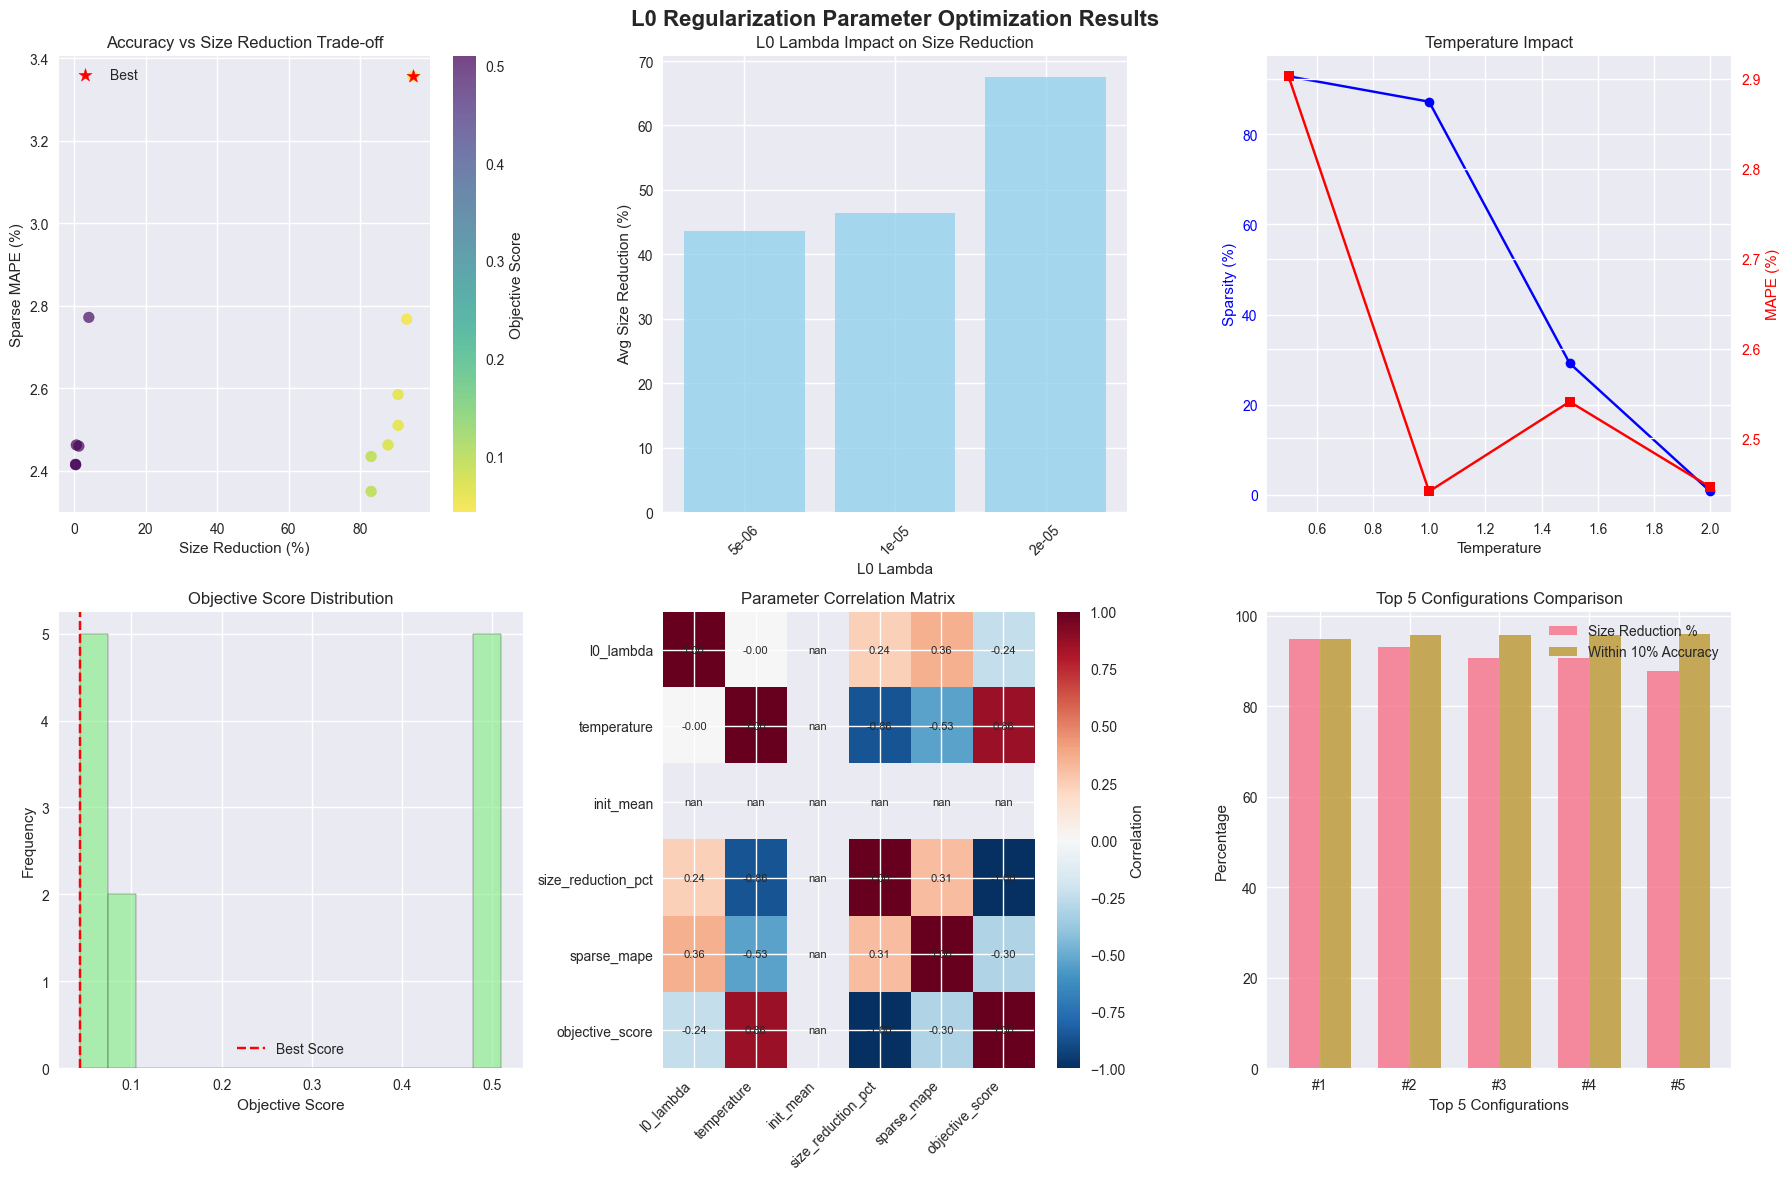


📈 Visualization complete! Key insights:
• Best configuration achieves 94.8% size reduction
• With 95% of targets within 10% accuracy
• Optimal L0 lambda appears to be around 2e-05


In [9]:
if len(successful_results) > 0:
    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('L0 Regularization Parameter Optimization Results', fontsize=16, fontweight='bold')
    
    # 1. Accuracy vs Size Reduction Trade-off
    scatter = axes[0,0].scatter(results_df['size_reduction_pct'], results_df['sparse_mape'], 
                              c=results_df['objective_score'], cmap='viridis_r', 
                              s=60, alpha=0.7)
    axes[0,0].set_xlabel('Size Reduction (%)')
    axes[0,0].set_ylabel('Sparse MAPE (%)')
    axes[0,0].set_title('Accuracy vs Size Reduction Trade-off')
    plt.colorbar(scatter, ax=axes[0,0], label='Objective Score')
    
    # Mark best point
    best_idx = results_df['objective_score'].idxmin()
    axes[0,0].scatter(results_df.loc[best_idx, 'size_reduction_pct'], 
                     results_df.loc[best_idx, 'sparse_mape'],
                     color='red', s=100, marker='*', label='Best')
    axes[0,0].legend()
    
    # 2. L0 Lambda Impact
    lambda_groups = results_df.groupby('l0_lambda').agg({
        'size_reduction_pct': 'mean',
        'sparse_mape': 'mean',
        'objective_score': 'mean'
    }).reset_index()
    
    axes[0,1].bar(range(len(lambda_groups)), lambda_groups['size_reduction_pct'], 
                 alpha=0.7, color='skyblue')
    axes[0,1].set_xlabel('L0 Lambda')
    axes[0,1].set_ylabel('Avg Size Reduction (%)')
    axes[0,1].set_title('L0 Lambda Impact on Size Reduction')
    axes[0,1].set_xticks(range(len(lambda_groups)))
    axes[0,1].set_xticklabels([f'{x:.0e}' for x in lambda_groups['l0_lambda']], rotation=45)
    
    # 3. Temperature Impact
    temp_groups = results_df.groupby('temperature').agg({
        'sparsity_ratio': 'mean',
        'sparse_mape': 'mean'
    }).reset_index()
    
    ax3_twin = axes[0,2].twinx()
    axes[0,2].plot(temp_groups['temperature'], temp_groups['sparsity_ratio'] * 100, 
                  'o-', color='blue', label='Sparsity %')
    ax3_twin.plot(temp_groups['temperature'], temp_groups['sparse_mape'], 
                 's-', color='red', label='MAPE %')
    
    axes[0,2].set_xlabel('Temperature')
    axes[0,2].set_ylabel('Sparsity (%)', color='blue')
    ax3_twin.set_ylabel('MAPE (%)', color='red')
    axes[0,2].set_title('Temperature Impact')
    axes[0,2].tick_params(axis='y', labelcolor='blue')
    ax3_twin.tick_params(axis='y', labelcolor='red')
    
    # 4. Objective Score Distribution
    axes[1,0].hist(results_df['objective_score'], bins=15, alpha=0.7, 
                  color='lightgreen', edgecolor='black')
    axes[1,0].axvline(results_df['objective_score'].min(), color='red', 
                     linestyle='--', label='Best Score')
    axes[1,0].set_xlabel('Objective Score')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].set_title('Objective Score Distribution')
    axes[1,0].legend()
    
    # 5. Parameter Correlation Heatmap
    param_cols = ['l0_lambda', 'temperature', 'init_mean', 'size_reduction_pct', 
                  'sparse_mape', 'objective_score']
    corr_matrix = results_df[param_cols].corr()
    
    im = axes[1,1].imshow(corr_matrix, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
    axes[1,1].set_xticks(range(len(param_cols)))
    axes[1,1].set_yticks(range(len(param_cols)))
    axes[1,1].set_xticklabels(param_cols, rotation=45, ha='right')
    axes[1,1].set_yticklabels(param_cols)
    axes[1,1].set_title('Parameter Correlation Matrix')
    
    # Add correlation values
    for i in range(len(param_cols)):
        for j in range(len(param_cols)):
            axes[1,1].text(j, i, f'{corr_matrix.iloc[i,j]:.2f}', 
                          ha='center', va='center', fontsize=8)
    
    plt.colorbar(im, ax=axes[1,1], label='Correlation')
    
    # 6. Top Configurations Comparison
    top_5 = results_df.nsmallest(5, 'objective_score')
    x_pos = np.arange(len(top_5))
    
    width = 0.35
    axes[1,2].bar(x_pos - width/2, top_5['size_reduction_pct'], width, 
                 label='Size Reduction %', alpha=0.8)
    axes[1,2].bar(x_pos + width/2, top_5['sparse_within_10pct'], width, 
                 label='Within 10% Accuracy', alpha=0.8)
    
    axes[1,2].set_xlabel('Top 5 Configurations')
    axes[1,2].set_ylabel('Percentage')
    axes[1,2].set_title('Top 5 Configurations Comparison')
    axes[1,2].set_xticks(x_pos)
    axes[1,2].set_xticklabels([f'#{i+1}' for i in range(len(top_5))])
    axes[1,2].legend()
    
    plt.tight_layout()
    plt.show()
    
    print("\n📈 Visualization complete! Key insights:")
    print(f"• Best configuration achieves {results_df.loc[best_idx, 'size_reduction_pct']:.1f}% size reduction")
    print(f"• With {results_df.loc[best_idx, 'sparse_within_10pct']:.0f}% of targets within 10% accuracy")
    print(f"• Optimal L0 lambda appears to be around {results_df.loc[best_idx, 'l0_lambda']:.0e}")
else:
    print("No successful results to visualize. Try adjusting parameters or increasing epochs.")

## Export Results

Save the optimization results for future reference and use.

In [10]:
if len(successful_results) > 0:
    # Create output directory
    output_dir = Path('../results')
    output_dir.mkdir(exist_ok=True)
    
    # Save full results
    results_df.to_csv(output_dir / 'l0_optimization_results.csv', index=False)
    
    # Save top 10 configurations
    top_10 = results_df.nsmallest(10, 'objective_score')
    top_10.to_csv(output_dir / 'top_10_l0_configurations.csv', index=False)
    
    # Export calibration logs for dashboard
    print("📊 Exporting calibration logs for top 10 configurations...")
    calibration_log_df = export_calibration_logs(results_df, target_names, output_dir)
    
    # Save best configuration details
    best_config_dict = results_df.loc[results_df['objective_score'].idxmin()].to_dict()
    
    with open(output_dir / 'best_l0_configuration.txt', 'w') as f:
        f.write("BEST L0 REGULARIZATION CONFIGURATION\n")
        f.write("=" * 50 + "\n\n")
        
        f.write("Parameters:\n")
        f.write(f"  l0_lambda: {best_config_dict['l0_lambda']:.0e}\n")
        f.write(f"  temperature: {best_config_dict['temperature']}\n")
        f.write(f"  init_mean: {best_config_dict['init_mean']}\n\n")
        
        f.write("Performance:\n")
        f.write(f"  Size Reduction: {best_config_dict['size_reduction_pct']:.1f}%\n")
        f.write(f"  Sparse MRAE: {best_config_dict['sparse_mrae']:.2f}%\n")
        f.write(f"  Within 10% Accuracy: {best_config_dict['sparse_within_10pct']:.0f}%\n")
        f.write(f"  Objective Score: {best_config_dict['objective_score']:.4f}\n")
    
    print(f"\n💾 Results exported to {output_dir}/")
    print(f"  • Full results: l0_optimization_results.csv")
    print(f"  • Top 10 configs: top_10_l0_configurations.csv")
    print(f"  • Calibration log: calibration_log.csv")
    print(f"  • Best config details: best_l0_configuration.txt")
    
    if calibration_log_df is not None:
        print(f"\n📈 Calibration Log Summary:")
        print(f"  • Total entries: {len(calibration_log_df):,}")
        print(f"  • Configurations: {calibration_log_df['rank'].nunique()}")
        print(f"  • Targets per config: {len(calibration_log_df) // calibration_log_df['rank'].nunique():,}")
        print(f"  • Average loss (MRAE): {calibration_log_df['loss'].mean():.4f}")
        print(f"  • Loss range: {calibration_log_df['loss'].min():.4f} - {calibration_log_df['loss'].max():.4f}")
else:
    print("No results to export.")

📊 Exporting calibration logs for top 10 configurations...
❌ No calibration logs could be generated

💾 Results exported to ../results/
  • Full results: l0_optimization_results.csv
  • Top 10 configs: top_10_l0_configurations.csv
  • Calibration log: calibration_log.csv
  • Best config details: best_l0_configuration.txt
